In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Homework part I: Prohibited Comment Classification (3 points)

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [4]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [5]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [6]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [8]:
# task: preprocess each comment in train and test

texts_train = list(map(preprocess, texts_train))
texts_test = list(map(preprocess, texts_test))

In [9]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [25]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = 10000

from collections import Counter

c = Counter()
for train_sentence in texts_train:
    c.update(train_sentence.split())

bow_vocabulary = [token for token, _ in c.most_common(k)]

print('example features:', sorted(bow_vocabulary)[::1000])

example features: ['!', 'came', 'faggot', 'lets', 'punctuation', 'theoretical']


In [208]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    counter = Counter(text.split())
    vec = [counter[token] for token in bow_vocabulary]
    return np.array(vec, 'float32')

In [209]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [210]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Machine learning stuff: fit, predict, evaluate. You know the drill.

In [211]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

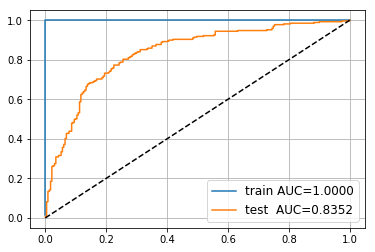

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }} $$


, where x is a single text D is your dataset (a collection of texts), N is total number of words and $\alpha$ is a smoothing hyperparameter (typically 1).

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :) You can still use 'em for debugging though.

**Remark**: N is total number of documents

Let's start!
```
1) implement tf-idf features
2) train a model
3) evaluate ROC curve
4) compare with BagOfWords
```

In [166]:
class CustomTfidfVectorizer(object):
    """ Simple version of TfidfVectorizer for our purposes """
    def __init__(self, vocab, alpha=1., smoothing_idf=False):
        self._vocab = vocab
        self._alpha = alpha
        self._smoothing_idf = smoothing_idf
        self._idf = None

    def _compute_word_in_text_freq(self, texts):
        words_freqs = np.zeros(len(self._vocab))
        for text in texts:
            occurences = Counter(text.split())
            for i, token in enumerate(self._vocab):
                if token in occurences:
                    words_freqs[i] += 1
        return words_freqs
    
    def _tf(self, text):
        counter = Counter(text.split())
        return np.array([counter[token] for token in self._vocab], 'float32')
    
    def fit(self, texts):
        words_freqs = self._compute_word_in_text_freq(texts)
        if self._smoothing_idf:  # exactly like from TfidfVectorizer
            self._idf = np.log((1.+len(texts)) / (words_freqs + 1.)) + 1.
            return
        self._idf = np.log(len(texts) / (words_freqs + self._alpha))

    def transform(self, text):
        if not isinstance(text, str):
            raise RuntimeError("Not implemented")
        assert(self._idf is not None)
        result = self._tf(text) * self._idf
        norm = np.linalg.norm(result)
        return result / np.maximum(norm, 1e-40)

Check on the second sentence, that our custom tf-idf vectorizer works almost equally to TfidfVectorizer from sklearn:

In [150]:
sentence_to_check = texts_train[2:3]
print(sentence_to_check)

['henry lee lucas was my dad im pretty sure i know the information better than you do .']


In [167]:
# Default TfidfVectorizer:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(norm='l2', vocabulary=bow_vocabulary, tokenizer=lambda x: x.split())
tfidf_vectorizer.fit(texts_train)
vec1 = np.asarray(tfidf_vectorizer.transform(sentence_to_check).todense())[0]

# Custom TfidfVectorizer:
custom_tfidf_vectorizer = CustomTfidfVectorizer(bow_vocabulary, smoothing_idf=True)
custom_tfidf_vectorizer.fit(texts_train)
vec2 = custom_tfidf_vectorizer.transform(sentence_to_check[0])

# Check:
assert np.all(vec1 == vec2)
assert np.all(tfidf_vectorizer.idf_ == custom_tfidf_vectorizer._idf)

Let's check with **smoothing_idf**: *off* and *on*

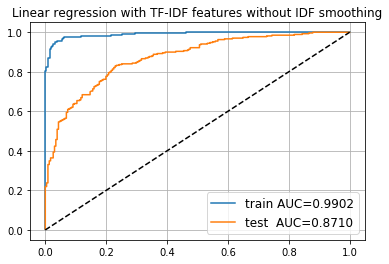

In [172]:
tfidf_vectorizer = CustomTfidfVectorizer(bow_vocabulary, smoothing_idf=False)
tfidf_vectorizer.fit(texts_train)

X_train_bow = np.stack(list(map(tfidf_vectorizer.transform, texts_train)))
X_test_bow = np.stack(list(map(tfidf_vectorizer.transform, texts_test)))

model = LogisticRegression().fit(X_train_bow, y_train)

for name, X, y, model in [
    ('train', X_train_bow, y_train, model),
    ('test ', X_test_bow, y_test, model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))


plt.title('Linear regression with TF-IDF features without IDF smoothing')
plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

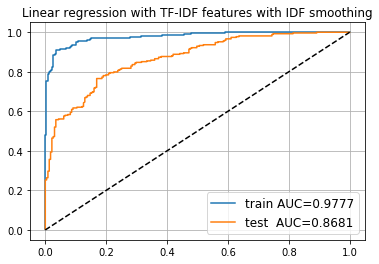

In [173]:
tfidf_vectorizer = CustomTfidfVectorizer(bow_vocabulary, smoothing_idf=True)
tfidf_vectorizer.fit(texts_train)

X_train_bow = np.stack(list(map(tfidf_vectorizer.transform, texts_train)))
X_test_bow = np.stack(list(map(tfidf_vectorizer.transform, texts_test)))

model = LogisticRegression().fit(X_train_bow, y_train)

for name, X, y, model in [
    ('train', X_train_bow, y_train, model),
    ('test ', X_test_bow, y_test, model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.title('Linear regression with TF-IDF features with IDF smoothing')
plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Got way better results!

AUC ~ 0.87 in both cases, but in the simple model with words counters we got: AUC ~ 0.84

IDF normalization helps to increase importance of rare words in documents.

Also, it is interesting to see which words got which idf weights

In [187]:
tfidf_vectorizer = CustomTfidfVectorizer(bow_vocabulary, smoothing_idf=True)
tfidf_vectorizer.fit(texts_train)

In [188]:
sorted_words_by_idf = sorted(zip(tfidf_vectorizer._idf, bow_vocabulary))

In [189]:
import pprint

In [194]:
print('less important tokens:')
pprint.pprint(sorted_words_by_idf[:5])
print('the most important tokens:')
pprint.pprint(sorted_words_by_idf[-80:-70])
print('...')
pprint.pprint(sorted_words_by_idf[-5:])

less important tokens:
[(1.2633627667970806, '.'),
 (1.5432828339133724, ','),
 (1.5501794129724327, 'the'),
 (1.6792718340663284, 'to'),
 (1.6871770135734416, 'you')]
the most important tokens:
[(6.523458920524919, 'zeus'),
 (6.523458920524919, 'zinta'),
 (6.523458920524919, 'zionism'),
 (6.523458920524919, 'zionists'),
 (6.523458920524919, 'zoey'),
 (6.523458920524919, 'zone'),
 (6.523458920524919, 'zoroastrianism'),
 (6.523458920524919, 'zu'),
 (6.523458920524919, '}:'),
 (6.523458920524919, '\x95')]
...
[(6.523458920524919, '♩'),
 (6.523458920524919, '♬'),
 (6.523458920524919, '✍'),
 (6.523458920524919, '❤'),
 (6.523458920524919, '𒁳')]


We can see, that idfs of the most important tokens are the same because of formula and there is a room to improve this model even further.

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [195]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead. Ignore all further asserts.

[==================================================] 100.0% 958.5/958.4MB downloaded


In [205]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    for token in comment.split():
        if token in embeddings:
            features += embeddings[token]    
    return features

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

In [206]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

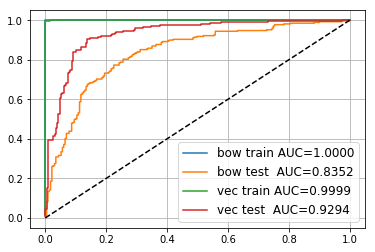

In [212]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.

Let's check another approaches - multiplying word vectors by words importance.

But we have at least one problem: we should hypothesize about unseen tokens.

Let's take this formula:

$$ weight_i = (0.5 + 0.5 * \frac{Count(word_i \in x)}{\max(Count(word_i \in x)}) \times (\log(\frac{N + 1}{Count(word_i \in D) + 1}) + 1)$$

and normalize afterwards. So we can now compute the weight for every word in document $x$

In [281]:
class ImportanceEvaluator(object):
    def __init__(self, vocab):
        self._vocab = vocab

        self._train_texts_count = None
        self._tokens_freqs = None

    def _compute_word_in_text_freq(self, texts):
        words_freqs = np.zeros(len(self._vocab))
        for text in texts:
            occurences = Counter(text.split())
            for i, token in enumerate(self._vocab):
                if token in occurences:
                    words_freqs[i] += 1
        return words_freqs
    
    def _double_normalized_tf(self, text):
        tokens = text.split()
        counter = Counter(tokens)
        max_freq = counter.most_common(1)[0][1]
        
        # augmented frequency
        term_in_doc_freq = lambda token: 0.5 + 0.5 * counter[token] / max_freq
        
        return np.array(list(map(term_in_doc_freq, tokens)), 'float32')
    
    def _get_token_freq(self, token):
        return np.log((self._train_texts_count + 1) / (self._tokens_freqs.get(token, 0) + 1)) + 1
    
    def fit(self, texts):
        tokens_freqs = self._compute_word_in_text_freq(texts)
        self._train_texts_count = len(texts)
        self._tokens_freqs = {token: freq for token, freq in zip(self._vocab, tokens_freqs)}

    def transform(self, text):
        if not isinstance(text, str):
            raise RuntimeError("Not implemented")
        
        weights = self._double_normalized_tf(text)
        result = weights * np.array(list(map(self._get_token_freq, text.split())))
        norm = np.linalg.norm(result)
        return result / np.maximum(norm, 1e-40)

In [282]:
imp_evaluator = ImportanceEvaluator(bow_vocabulary)
imp_evaluator.fit(texts_train)

In [283]:
def vectorize(comment):
    """
    implement a function that converts preprocessed comment to a weighted sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    tokens_imps = imp_evaluator.transform(comment)

    for i, token in enumerate(comment.split()):
        if token in embeddings:
            features += embeddings[token] * tokens_imps[i]
    return features

X_train_wv = np.stack([vectorize(text) for text in texts_train])
X_test_wv = np.stack([vectorize(text) for text in texts_test])

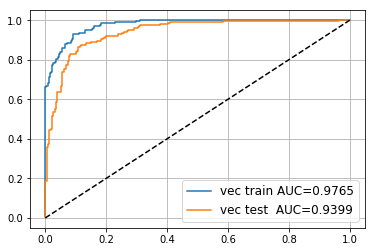

In [284]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

With weights we get even better results: AUC = 0.94 (only sum give 0.93)